# e23 SparseGT Tuning Analysis

This notebook analyzes the hyperparameter tuning experiment for SparseGT on res04.

**Grid Search Parameters:**
- `num_hops`: [3, 5, 7]
- `num_layers`: [2, 3, 4, 5]
- `hidden_dim`: [64, 128, 256]
- `dropout` (and `attn_dropout`): [0.0, 0.01, 0.05]

**Fixed Settings:**
- Resolution: res04
- Epochs: 10
- lr: 0.0001
- batch_size: 512

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import wandb_buddy as wb
from tqdm import tqdm

## Notebook Parameters

In [2]:
TAG = "e23_sgt_tuning"
ENTITY = "alelab"
PROJECT = "terrains"

# Metrics
ERROR_COL = 'val_mae'
ERROR_LABEL = 'Validation MAE'

## Fetch Runs from Wandb

In [3]:
print(f"Fetching runs with tag: {TAG}")
df = wb.load_runs(ENTITY, PROJECT, tags=[TAG],state='all')
print(f"Found {len(df)} runs")

Fetching runs with tag: e23_sgt_tuning


wandb: Currently logged in as: jotaporras (alelab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Found 40 runs


In [4]:
# Check run states
print("Run states:")
print(df['state'].value_counts())

Run states:
state
crashed     35
finished     5
Name: count, dtype: int64


## Extract Hyperparameters

The SparseGT config is logged to wandb with columns like `sparse_gt_num_hops`, `sparse_gt_num_layers`, etc.

In [5]:
# Check available sparse_gt columns
sgt_cols = [c for c in df.columns if 'sparse_gt' in c.lower()]
print("SparseGT config columns:")
for col in sgt_cols:
    print(f"  {col}")

SparseGT config columns:
  sparse_gt_dropout
  sparse_gt_num_hops
  sparse_gt_input_dim
  sparse_gt_num_heads
  sparse_gt_hidden_dim
  sparse_gt_num_layers
  sparse_gt_output_dim
  sparse_gt_attn_dropout
  sparse_gt_rpearl_samples
  sparse_gt_rpearl_num_layers


In [6]:
# Rename columns for easier access
hp_mapping = {
    'sparse_gt_num_hops': 'num_hops',
    'sparse_gt_num_layers': 'num_layers', 
    'sparse_gt_hidden_dim': 'hidden_dim',
    'sparse_gt_dropout': 'dropout',
    'sparse_gt_attn_dropout': 'attn_dropout'
}

for old_col, new_col in hp_mapping.items():
    if old_col in df.columns:
        df[new_col] = df[old_col]

# Verify hyperparameters are extracted
print("Hyperparameter coverage:")
for col in ['num_hops', 'num_layers', 'hidden_dim', 'dropout']:
    if col in df.columns:
        print(f"  {col}: {df[col].notna().sum()}/{len(df)} valid, values: {sorted(df[col].dropna().unique())}")

Hyperparameter coverage:
  num_hops: 40/40 valid, values: [np.int64(3), np.int64(5), np.int64(7)]
  num_layers: 40/40 valid, values: [np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  hidden_dim: 40/40 valid, values: [np.int64(64), np.int64(128), np.int64(256)]
  dropout: 40/40 valid, values: [np.float64(0.0), np.float64(0.01)]


## Compute Validation MAE from History

Similar to the e23 analysis, we fetch `val_batch_mae` history from wandb and average over all logged batches to get the true validation MAE.

In [7]:
def get_metric_history_mean(entity: str, project: str, run_id: str, metric: str) -> float:
    """
    Fetch the full history of a metric from a wandb run and return its mean.
    """
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    history = run.history(keys=[metric], pandas=True)
    
    if history.empty or metric not in history.columns:
        return np.nan
    
    values = history[metric].dropna()
    if len(values) == 0:
        return np.nan
    
    return values.mean()


def add_metric_from_history(df: pd.DataFrame, entity: str, project: str, 
                            source_metric: str, target_col: str) -> pd.DataFrame:
    """
    Add a new column to df by fetching metric history from wandb and computing the mean.
    """
    means = []
    for run_id in tqdm(df['id'], desc=f"Fetching {source_metric} history"):
        mean_val = get_metric_history_mean(entity, project, run_id, source_metric)
        means.append(mean_val)
    
    df[target_col] = means
    return df

In [8]:
# Fetch val_mae from history
# First check if val_mae is already available in summary
if 'val_mae' in df.columns and df['val_mae'].notna().sum() > 0:
    print(f"Using existing val_mae from summary: {df['val_mae'].notna().sum()}/{len(df)} valid")
else:
    print("Fetching val_mae from val_batch_mae history...")
    df = add_metric_from_history(df, ENTITY, PROJECT, 'val_batch_mae', 'val_mae')
    print(f"Runs with valid val_mae: {df['val_mae'].notna().sum()}/{len(df)}")

Using existing val_mae from summary: 40/40 valid


## Summary Table

In [9]:
# Filter to valid runs with metrics
df_valid = df[df[ERROR_COL].notna()].copy()
print(f"Valid runs for analysis: {len(df_valid)}")

# Display summary sorted by val_mae
summary_cols = ['name', 'state', 'num_hops', 'num_layers', 'hidden_dim', 'dropout', ERROR_COL]
available_cols = [c for c in summary_cols if c in df_valid.columns]
df_valid[available_cols].sort_values(ERROR_COL).head(20)

Valid runs for analysis: 40


,name,state,num_hops,num_layers,hidden_dim,dropout,val_mae
31,terrain-graph-SparseGT-res04-stage1,crashed,7,5,256,0.0,0.169355
35,terrain-graph-SparseGT-res04-stage1,crashed,5,5,256,0.0,0.169543
37,terrain-graph-SparseGT-res04-stage1,crashed,3,5,256,0.0,0.170194
20,terrain-graph-SparseGT-res04-stage1,finished,7,4,128,0.0,0.173201
33,terrain-graph-SparseGT-res04-stage1,crashed,7,4,256,0.0,0.173593
30,terrain-graph-SparseGT-res04-stage1,crashed,3,4,256,0.0,0.173638
32,terrain-graph-SparseGT-res04-stage1,crashed,5,4,256,0.0,0.173823
13,terrain-graph-SparseGT-res04-stage1,crashed,3,4,128,0.0,0.174152
25,terrain-graph-SparseGT-res04-stage1,crashed,5,5,128,0.0,0.174314
26,terrain-graph-SparseGT-res04-stage1,crashed,7,5,128,0.0,0.174368


## Best Configuration

In [10]:
if len(df_valid) > 0:
    best_idx = df_valid[ERROR_COL].idxmin()
    best_run = df_valid.loc[best_idx]
    
    print("=" * 50)
    print("BEST CONFIGURATION")
    print("=" * 50)
    print(f"  Run: {best_run['name']}")
    print(f"  {ERROR_LABEL}: {best_run[ERROR_COL]:.6f}")
    print()
    print("Hyperparameters:")
    for col in ['num_hops', 'num_layers', 'hidden_dim', 'dropout']:
        if col in best_run.index:
            print(f"  {col}: {best_run[col]}")
else:
    print("No valid runs found yet.")

BEST CONFIGURATION
  Run: terrain-graph-SparseGT-res04-stage1
  Validation MAE: 0.169355

Hyperparameters:
  num_hops: 7
  num_layers: 5
  hidden_dim: 256
  dropout: 0.0


## Hyperparameter Analysis Plots

In [11]:
sns.set_theme(style="whitegrid", font_scale=1.1)

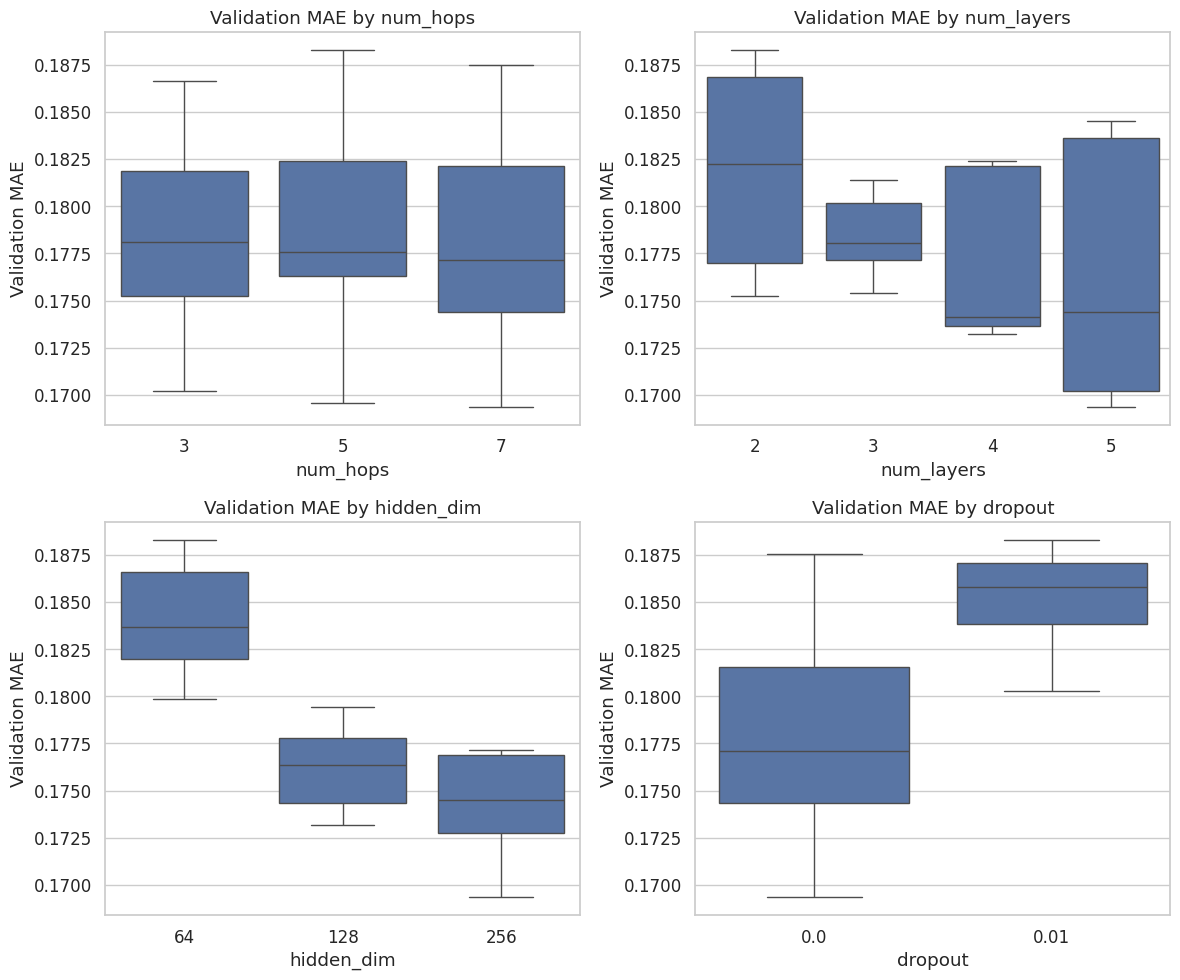

In [12]:
# Box plots for each hyperparameter
if len(df_valid) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    hp_cols = ['num_hops', 'num_layers', 'hidden_dim', 'dropout']
    
    for ax, col in zip(axes.flat, hp_cols):
        if col in df_valid.columns:
            sns.boxplot(data=df_valid, x=col, y=ERROR_COL, ax=ax)
            ax.set_xlabel(col)
            ax.set_ylabel(ERROR_LABEL)
            ax.set_title(f'{ERROR_LABEL} by {col}')
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid runs to plot.")

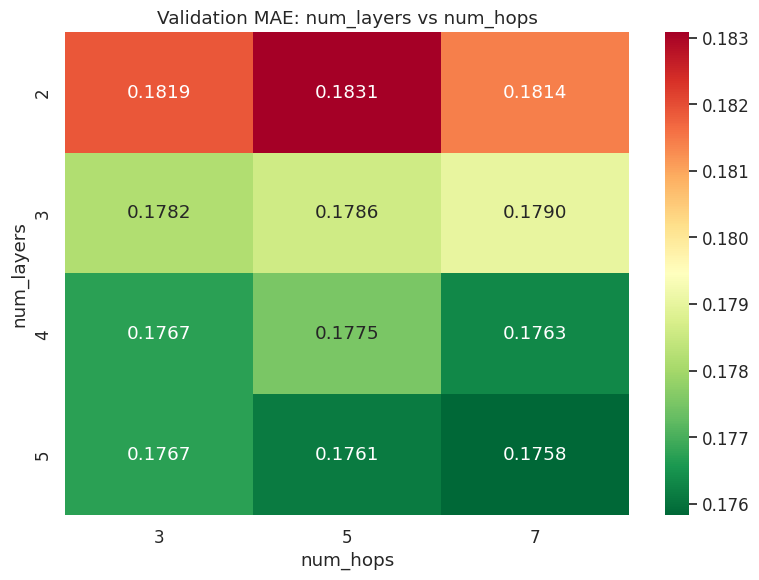

In [13]:
# Heatmap: num_hops vs num_layers (averaged over other params)
if len(df_valid) > 0 and 'num_hops' in df_valid.columns and 'num_layers' in df_valid.columns:
    pivot_hops_layers = df_valid.pivot_table(
        values=ERROR_COL, 
        index='num_layers', 
        columns='num_hops', 
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pivot_hops_layers, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax)
    ax.set_title(f'{ERROR_LABEL}: num_layers vs num_hops')
    ax.set_xlabel('num_hops')
    ax.set_ylabel('num_layers')
    plt.tight_layout()
    plt.show()

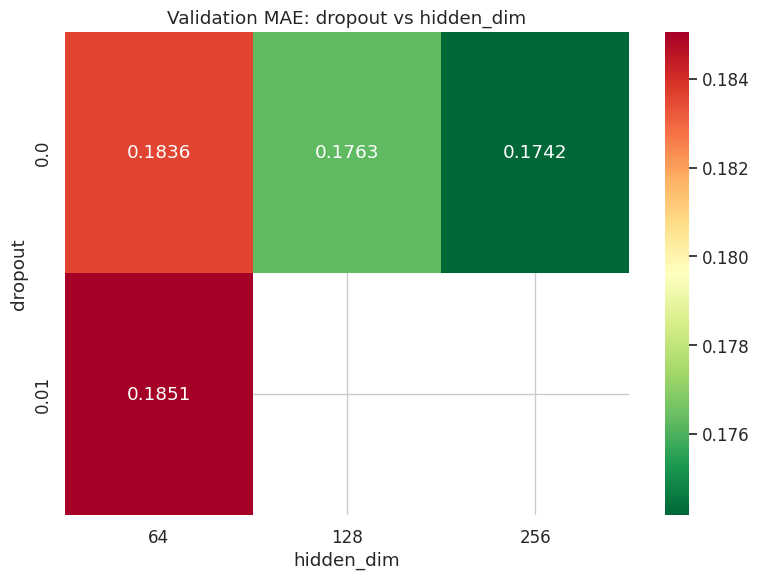

In [14]:
# Heatmap: hidden_dim vs dropout (averaged over other params)
if len(df_valid) > 0 and 'hidden_dim' in df_valid.columns and 'dropout' in df_valid.columns:
    pivot_dim_drop = df_valid.pivot_table(
        values=ERROR_COL, 
        index='dropout', 
        columns='hidden_dim', 
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pivot_dim_drop, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax)
    ax.set_title(f'{ERROR_LABEL}: dropout vs hidden_dim')
    ax.set_xlabel('hidden_dim')
    ax.set_ylabel('dropout')
    plt.tight_layout()
    plt.show()

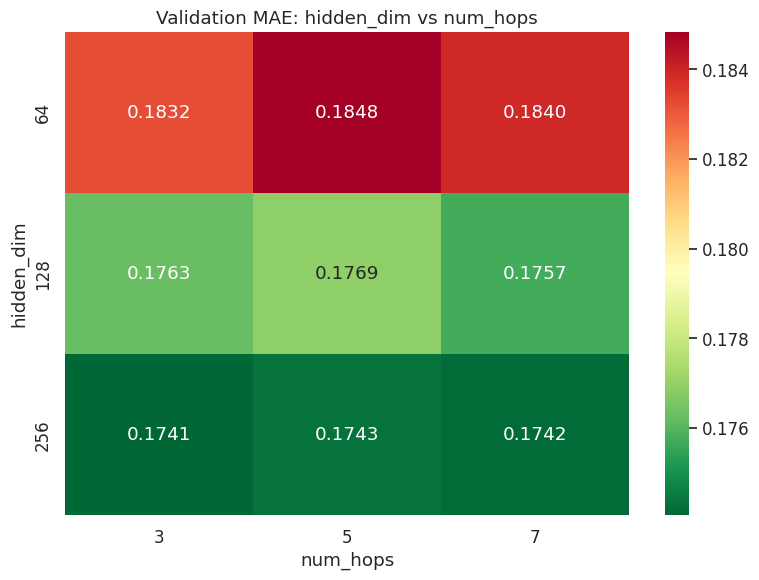

In [15]:
# Heatmap: num_hops vs hidden_dim
if len(df_valid) > 0 and 'num_hops' in df_valid.columns and 'hidden_dim' in df_valid.columns:
    pivot_hops_dim = df_valid.pivot_table(
        values=ERROR_COL, 
        index='hidden_dim', 
        columns='num_hops', 
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pivot_hops_dim, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax)
    ax.set_title(f'{ERROR_LABEL}: hidden_dim vs num_hops')
    ax.set_xlabel('num_hops')
    ax.set_ylabel('hidden_dim')
    plt.tight_layout()
    plt.show()

## Mean Performance by Hyperparameter

In [16]:
if len(df_valid) > 0:
    print("Mean {} by hyperparameter:\n".format(ERROR_LABEL))
    
    for col in ['num_hops', 'num_layers', 'hidden_dim', 'dropout']:
        if col in df_valid.columns:
            means = df_valid.groupby(col)[ERROR_COL].agg(['mean', 'std', 'count'])
            print(f"\n{col}:")
            print(means.round(4).to_string())

Mean Validation MAE by hyperparameter:


num_hops:
            mean     std  count
num_hops                       
3         0.1786  0.0049     14
5         0.1792  0.0055     13
7         0.1784  0.0053     13

num_layers:
              mean     std  count
num_layers                       
2           0.1821  0.0052     12
3           0.1786  0.0021     10
4           0.1769  0.0042      9
5           0.1762  0.0063      9

hidden_dim:
              mean     std  count
hidden_dim                       
64          0.1840  0.0027     16
128         0.1763  0.0021     12
256         0.1742  0.0030     12

dropout:
           mean     std  count
dropout                       
0.00     0.1780  0.0048     36
0.01     0.1851  0.0035      4


## Top 10 Configurations

In [17]:
if len(df_valid) > 0:
    top10 = df_valid.nsmallest(10, ERROR_COL)
    display_cols = ['num_hops', 'num_layers', 'hidden_dim', 'dropout', ERROR_COL, 'name']
    available_display = [c for c in display_cols if c in top10.columns]
    
    print("Top 10 Configurations:")
    print(top10[available_display].to_string(index=False))

Top 10 Configurations:
 num_hops  num_layers  hidden_dim  dropout  val_mae                                name
        7           5         256      0.0 0.169355 terrain-graph-SparseGT-res04-stage1
        5           5         256      0.0 0.169543 terrain-graph-SparseGT-res04-stage1
        3           5         256      0.0 0.170194 terrain-graph-SparseGT-res04-stage1
        7           4         128      0.0 0.173201 terrain-graph-SparseGT-res04-stage1
        7           4         256      0.0 0.173593 terrain-graph-SparseGT-res04-stage1
        3           4         256      0.0 0.173638 terrain-graph-SparseGT-res04-stage1
        5           4         256      0.0 0.173823 terrain-graph-SparseGT-res04-stage1
        3           4         128      0.0 0.174152 terrain-graph-SparseGT-res04-stage1
        5           5         128      0.0 0.174314 terrain-graph-SparseGT-res04-stage1
        7           5         128      0.0 0.174368 terrain-graph-SparseGT-res04-stage1


## Recommendations

Based on the tuning results, update `configs/sparse-gt-rpearl-k5.yml` with the optimal hyperparameters and re-run the full e23 experiment.

In [18]:
if len(df_valid) > 0:
    best = df_valid.loc[df_valid[ERROR_COL].idxmin()]
    
    print("Recommended config update for sparse-gt-rpearl-k5.yml:")
    print()
    print("sparse_gt:")
    if 'hidden_dim' in best.index:
        print(f"  hidden_dim: {int(best['hidden_dim'])}")
    if 'num_layers' in best.index:
        print(f"  num_layers: {int(best['num_layers'])}")
    print(f"  num_heads: 4")
    if 'num_hops' in best.index:
        print(f"  num_hops: {int(best['num_hops'])}")
    print(f"  rpearl_samples: 30")
    print(f"  rpearl_num_layers: 5")
    if 'dropout' in best.index:
        print(f"  dropout: {best['dropout']}")
        print(f"  attn_dropout: {best['dropout']}")

Recommended config update for sparse-gt-rpearl-k5.yml:

sparse_gt:
  hidden_dim: 256
  num_layers: 5
  num_heads: 4
  num_hops: 7
  rpearl_samples: 30
  rpearl_num_layers: 5
  dropout: 0.0
  attn_dropout: 0.0
